# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

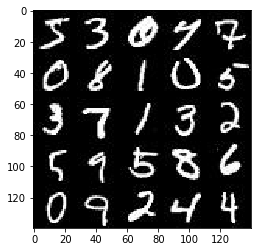

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

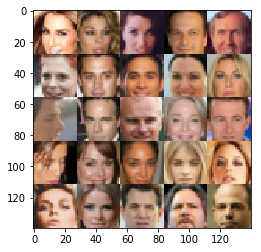

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


/Applications/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_inputs = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_inputs')
    lr = tf.placeholder(tf.float32, name='lr')
    return real_inputs, z_inputs, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        #print ('image',images.shape)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        x4 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn3, bn3)
        #print('relu_shape', relu4.shape)

        # Flatten it
        flat = tf.reshape(relu4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        #print ('z_shaoe',z.shape)
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print('x1_shape', x1.shape)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print('x2_shape', x2.shape)

        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print('x3_shape', x3.shape)


        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05)) 
        out = tf.tanh(logits)    
        return out
        
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Implement Function 
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    """
    tf.control_dependencies() is used in the batch normalization lessons, and is necessary to get
    the normalization layers created with tf.layers.batch_normalization to update their population 
    statistics, which we need when performing inference.

    """
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate*2, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model  
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels) 
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    #sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                #batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #batch_z = batch_z.reshape(batch_size, z_dim)

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/1... Discriminator Loss: 6.3909... Generator Loss: 0.0049
Epoch 1/1... Discriminator Loss: 4.9930... Generator Loss: 0.0203
Epoch 1/1... Discriminator Loss: 2.8057... Generator Loss: 0.1472
Epoch 1/1... Discriminator Loss: 1.7280... Generator Loss: 0.3830
Epoch 1/1... Discriminator Loss: 1.7048... Generator Loss: 0.3981
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 1.6934... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.4061
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 1.1213
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.7244


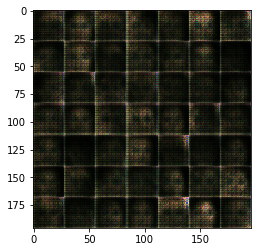

Epoch 1/1... Discriminator Loss: 1.5988... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 2.0136... Generator Loss: 0.2858
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 2.3480... Generator Loss: 0.1624
Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 0.6445


KeyboardInterrupt: 

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [ ]:
print('abc')

Epoch 1/2... Discriminator Loss: 2.0085... Generator Loss: 0.2441
Epoch 1/2... Discriminator Loss: 1.4153... Generator Loss: 0.4032
Epoch 1/2... Discriminator Loss: 1.5999... Generator Loss: 1.4589
Epoch 1/2... Discriminator Loss: 2.6033... Generator Loss: 0.1306
Epoch 1/2... Discriminator Loss: 1.4409... Generator Loss: 0.6940
Epoch 1/2... Discriminator Loss: 1.6863... Generator Loss: 0.3531
Epoch 1/2... Discriminator Loss: 1.6763... Generator Loss: 0.9094
Epoch 1/2... Discriminator Loss: 1.4228... Generator Loss: 1.0999
Epoch 1/2... Discriminator Loss: 1.7928... Generator Loss: 0.9088
Epoch 1/2... Discriminator Loss: 1.8723... Generator Loss: 0.4421


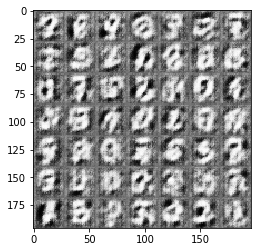

Epoch 1/2... Discriminator Loss: 2.1674... Generator Loss: 0.1968
Epoch 1/2... Discriminator Loss: 1.8328... Generator Loss: 1.1057
Epoch 1/2... Discriminator Loss: 1.6316... Generator Loss: 0.6558
Epoch 1/2... Discriminator Loss: 2.0838... Generator Loss: 0.1844
Epoch 1/2... Discriminator Loss: 1.6018... Generator Loss: 0.9437
Epoch 1/2... Discriminator Loss: 1.8603... Generator Loss: 0.5776
Epoch 1/2... Discriminator Loss: 1.1527... Generator Loss: 0.6313
Epoch 1/2... Discriminator Loss: 1.2855... Generator Loss: 0.7011
Epoch 1/2... Discriminator Loss: 0.9188... Generator Loss: 1.6451
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.5871


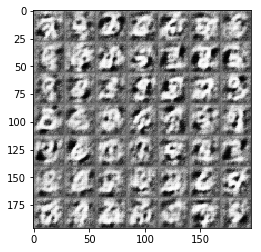

Epoch 1/2... Discriminator Loss: 1.6657... Generator Loss: 0.3251
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 0.5015
Epoch 1/2... Discriminator Loss: 1.1187... Generator Loss: 2.4198
Epoch 1/2... Discriminator Loss: 1.0359... Generator Loss: 0.6237
Epoch 1/2... Discriminator Loss: 1.6505... Generator Loss: 0.2847
Epoch 1/2... Discriminator Loss: 1.6729... Generator Loss: 0.2533
Epoch 1/2... Discriminator Loss: 0.9280... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 0.5087
Epoch 1/2... Discriminator Loss: 1.1157... Generator Loss: 1.6623
Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 0.5073


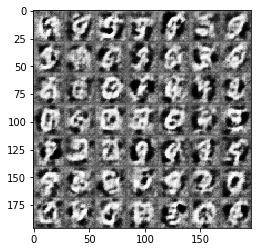

Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 0.4580
Epoch 1/2... Discriminator Loss: 1.1982... Generator Loss: 0.5057
Epoch 1/2... Discriminator Loss: 1.3729... Generator Loss: 1.1571
Epoch 1/2... Discriminator Loss: 0.9297... Generator Loss: 2.4641
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 0.6879
Epoch 1/2... Discriminator Loss: 1.4151... Generator Loss: 0.3772
Epoch 1/2... Discriminator Loss: 1.6208... Generator Loss: 1.4305
Epoch 1/2... Discriminator Loss: 1.3252... Generator Loss: 0.9179
Epoch 1/2... Discriminator Loss: 1.1674... Generator Loss: 1.1865
Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 1.3820


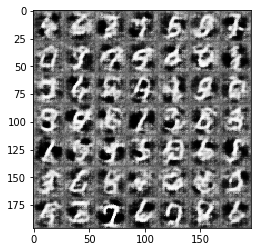

Epoch 1/2... Discriminator Loss: 1.3728... Generator Loss: 1.6551
Epoch 1/2... Discriminator Loss: 1.4919... Generator Loss: 0.3759
Epoch 1/2... Discriminator Loss: 1.0662... Generator Loss: 0.7916
Epoch 1/2... Discriminator Loss: 1.5652... Generator Loss: 0.3053
Epoch 1/2... Discriminator Loss: 1.2786... Generator Loss: 0.5438
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 0.6084
Epoch 1/2... Discriminator Loss: 1.4754... Generator Loss: 0.3575
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 1.1595
Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 1.8171
Epoch 1/2... Discriminator Loss: 1.2150... Generator Loss: 0.6323


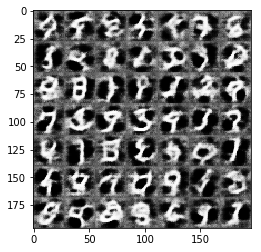

Epoch 1/2... Discriminator Loss: 1.2746... Generator Loss: 1.0271
Epoch 1/2... Discriminator Loss: 1.0053... Generator Loss: 0.8190
Epoch 1/2... Discriminator Loss: 1.6248... Generator Loss: 0.3155
Epoch 1/2... Discriminator Loss: 0.8430... Generator Loss: 1.5878
Epoch 1/2... Discriminator Loss: 1.1632... Generator Loss: 1.2825
Epoch 1/2... Discriminator Loss: 1.5513... Generator Loss: 1.3438
Epoch 1/2... Discriminator Loss: 1.3983... Generator Loss: 1.4950
Epoch 1/2... Discriminator Loss: 1.4678... Generator Loss: 0.3669
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 1.0598
Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 1.3862


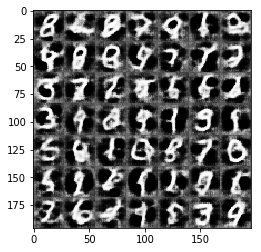

Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 0.4811
Epoch 1/2... Discriminator Loss: 1.2226... Generator Loss: 0.8074
Epoch 1/2... Discriminator Loss: 1.1128... Generator Loss: 0.9239
Epoch 1/2... Discriminator Loss: 1.2572... Generator Loss: 1.3096
Epoch 1/2... Discriminator Loss: 1.3742... Generator Loss: 0.3867
Epoch 1/2... Discriminator Loss: 1.0032... Generator Loss: 0.8346
Epoch 1/2... Discriminator Loss: 1.5035... Generator Loss: 0.3153
Epoch 1/2... Discriminator Loss: 1.2244... Generator Loss: 1.0576
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 0.5816
Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 0.7227


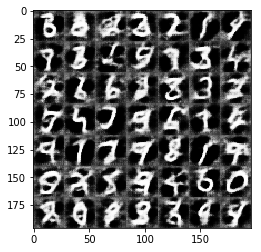

Epoch 1/2... Discriminator Loss: 1.2573... Generator Loss: 0.5700
Epoch 1/2... Discriminator Loss: 1.4608... Generator Loss: 0.3284
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.4368
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 1.3050
Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 1.6169
Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.3861
Epoch 1/2... Discriminator Loss: 0.9106... Generator Loss: 0.9553
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.3597
Epoch 1/2... Discriminator Loss: 0.8122... Generator Loss: 1.3551
Epoch 1/2... Discriminator Loss: 1.0900... Generator Loss: 0.6695


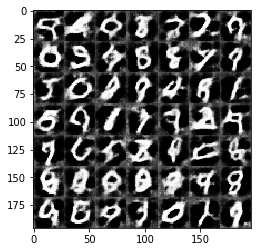

Epoch 1/2... Discriminator Loss: 1.0287... Generator Loss: 1.6584
Epoch 1/2... Discriminator Loss: 1.1990... Generator Loss: 1.8758
Epoch 1/2... Discriminator Loss: 0.8043... Generator Loss: 1.3129
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.4459
Epoch 1/2... Discriminator Loss: 1.3215... Generator Loss: 0.4198
Epoch 1/2... Discriminator Loss: 1.9260... Generator Loss: 0.2054
Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 0.8883
Epoch 1/2... Discriminator Loss: 0.8886... Generator Loss: 0.9653
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.4636
Epoch 1/2... Discriminator Loss: 1.1312... Generator Loss: 1.3061


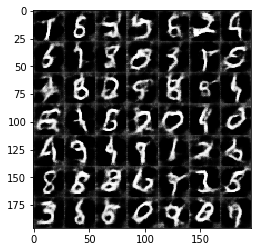

Epoch 1/2... Discriminator Loss: 2.2170... Generator Loss: 3.3417
Epoch 1/2... Discriminator Loss: 0.9686... Generator Loss: 0.8099
Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 0.6209
Epoch 2/2... Discriminator Loss: 0.8869... Generator Loss: 1.0628
Epoch 2/2... Discriminator Loss: 1.0338... Generator Loss: 0.6670
Epoch 2/2... Discriminator Loss: 1.5630... Generator Loss: 0.2895
Epoch 2/2... Discriminator Loss: 1.2337... Generator Loss: 0.4943
Epoch 2/2... Discriminator Loss: 0.9916... Generator Loss: 0.7028
Epoch 2/2... Discriminator Loss: 1.4173... Generator Loss: 0.3750
Epoch 2/2... Discriminator Loss: 1.2150... Generator Loss: 0.8491


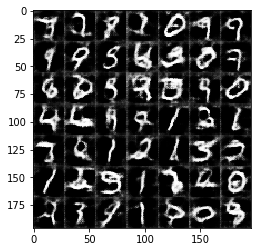

Epoch 2/2... Discriminator Loss: 0.9795... Generator Loss: 0.7818
Epoch 2/2... Discriminator Loss: 1.0011... Generator Loss: 0.7776
Epoch 2/2... Discriminator Loss: 1.0011... Generator Loss: 0.6737
Epoch 2/2... Discriminator Loss: 1.0282... Generator Loss: 1.0336
Epoch 2/2... Discriminator Loss: 1.0928... Generator Loss: 0.5576
Epoch 2/2... Discriminator Loss: 0.7656... Generator Loss: 1.4997
Epoch 2/2... Discriminator Loss: 0.7974... Generator Loss: 1.0274
Epoch 2/2... Discriminator Loss: 1.2947... Generator Loss: 1.0242
Epoch 2/2... Discriminator Loss: 1.1995... Generator Loss: 0.8509
Epoch 2/2... Discriminator Loss: 1.1238... Generator Loss: 0.5837


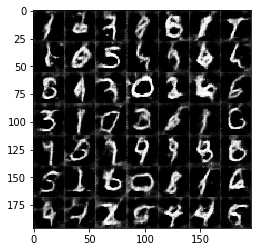

Epoch 2/2... Discriminator Loss: 1.1297... Generator Loss: 0.6305
Epoch 2/2... Discriminator Loss: 1.0696... Generator Loss: 1.2667
Epoch 2/2... Discriminator Loss: 1.2324... Generator Loss: 0.4857
Epoch 2/2... Discriminator Loss: 1.5031... Generator Loss: 0.3334
Epoch 2/2... Discriminator Loss: 0.8314... Generator Loss: 1.0873
Epoch 2/2... Discriminator Loss: 1.6635... Generator Loss: 0.3151
Epoch 2/2... Discriminator Loss: 1.1018... Generator Loss: 1.6932
Epoch 2/2... Discriminator Loss: 1.1982... Generator Loss: 0.5289
Epoch 2/2... Discriminator Loss: 1.5889... Generator Loss: 0.2869
Epoch 2/2... Discriminator Loss: 1.4674... Generator Loss: 0.4768


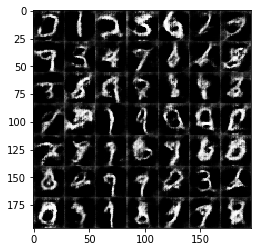

Epoch 2/2... Discriminator Loss: 1.0203... Generator Loss: 1.0714
Epoch 2/2... Discriminator Loss: 1.0936... Generator Loss: 0.9052
Epoch 2/2... Discriminator Loss: 1.1520... Generator Loss: 0.5812
Epoch 2/2... Discriminator Loss: 1.2083... Generator Loss: 0.5703
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 0.3949
Epoch 2/2... Discriminator Loss: 1.1080... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 1.2873... Generator Loss: 1.7481
Epoch 2/2... Discriminator Loss: 0.9393... Generator Loss: 0.9096
Epoch 2/2... Discriminator Loss: 0.7946... Generator Loss: 1.0631
Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 0.8579


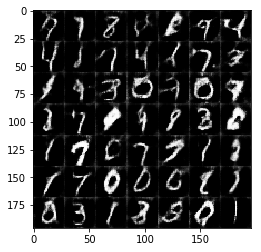

Epoch 2/2... Discriminator Loss: 0.7591... Generator Loss: 1.1157
Epoch 2/2... Discriminator Loss: 1.6152... Generator Loss: 0.3033
Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 0.7420
Epoch 2/2... Discriminator Loss: 0.9735... Generator Loss: 1.0832
Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 0.4560
Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 1.0906
Epoch 2/2... Discriminator Loss: 0.9829... Generator Loss: 1.2456
Epoch 2/2... Discriminator Loss: 1.9401... Generator Loss: 0.2818
Epoch 2/2... Discriminator Loss: 1.2971... Generator Loss: 0.4752
Epoch 2/2... Discriminator Loss: 0.9646... Generator Loss: 0.7700


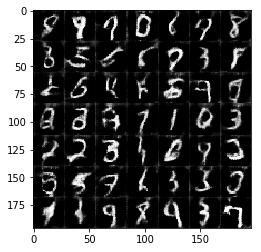

Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 0.6972
Epoch 2/2... Discriminator Loss: 1.1690... Generator Loss: 0.5307
Epoch 2/2... Discriminator Loss: 0.8819... Generator Loss: 1.4883
Epoch 2/2... Discriminator Loss: 0.9845... Generator Loss: 0.8582
Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 1.8039
Epoch 2/2... Discriminator Loss: 1.6424... Generator Loss: 2.0891
Epoch 2/2... Discriminator Loss: 0.9728... Generator Loss: 0.8554
Epoch 2/2... Discriminator Loss: 0.8655... Generator Loss: 1.1142
Epoch 2/2... Discriminator Loss: 0.7532... Generator Loss: 1.0814
Epoch 2/2... Discriminator Loss: 0.9783... Generator Loss: 0.7014


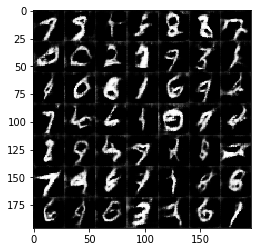

Epoch 2/2... Discriminator Loss: 1.3179... Generator Loss: 0.4255
Epoch 2/2... Discriminator Loss: 1.6692... Generator Loss: 0.3412
Epoch 2/2... Discriminator Loss: 1.1797... Generator Loss: 0.5224
Epoch 2/2... Discriminator Loss: 1.0567... Generator Loss: 0.7394
Epoch 2/2... Discriminator Loss: 1.0730... Generator Loss: 0.6236
Epoch 2/2... Discriminator Loss: 1.6552... Generator Loss: 0.2850
Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 0.8844
Epoch 2/2... Discriminator Loss: 0.9595... Generator Loss: 1.1165
Epoch 2/2... Discriminator Loss: 1.1785... Generator Loss: 2.0221
Epoch 2/2... Discriminator Loss: 1.5037... Generator Loss: 0.3502


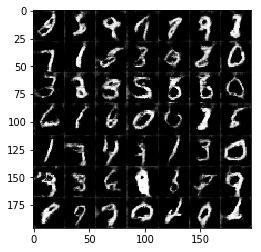

Epoch 2/2... Discriminator Loss: 1.5540... Generator Loss: 0.3220
Epoch 2/2... Discriminator Loss: 0.9574... Generator Loss: 2.0803
Epoch 2/2... Discriminator Loss: 0.9096... Generator Loss: 1.6285
Epoch 2/2... Discriminator Loss: 0.8355... Generator Loss: 0.9022
Epoch 2/2... Discriminator Loss: 0.8174... Generator Loss: 0.9025
Epoch 2/2... Discriminator Loss: 0.9919... Generator Loss: 1.8933
Epoch 2/2... Discriminator Loss: 0.8765... Generator Loss: 1.5391
Epoch 2/2... Discriminator Loss: 0.8123... Generator Loss: 1.1132
Epoch 2/2... Discriminator Loss: 0.8404... Generator Loss: 1.9278
Epoch 2/2... Discriminator Loss: 0.9148... Generator Loss: 0.7865


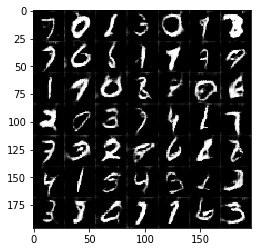

Epoch 2/2... Discriminator Loss: 1.1613... Generator Loss: 0.5864
Epoch 2/2... Discriminator Loss: 1.0749... Generator Loss: 0.7585
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 0.7172
Epoch 2/2... Discriminator Loss: 0.9996... Generator Loss: 1.0263
Epoch 2/2... Discriminator Loss: 0.7224... Generator Loss: 1.2510
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 0.4438
Epoch 2/2... Discriminator Loss: 0.8524... Generator Loss: 0.9597
Epoch 2/2... Discriminator Loss: 1.0835... Generator Loss: 0.8329
Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 1.4028
Epoch 2/2... Discriminator Loss: 1.6757... Generator Loss: 0.2521


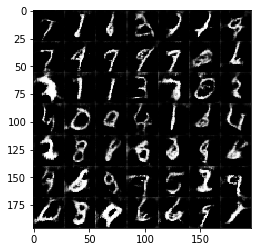

Epoch 2/2... Discriminator Loss: 0.9122... Generator Loss: 1.1352
Epoch 2/2... Discriminator Loss: 1.0871... Generator Loss: 0.6594
Epoch 2/2... Discriminator Loss: 1.4530... Generator Loss: 0.3469
Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 0.6146
Epoch 2/2... Discriminator Loss: 1.1665... Generator Loss: 2.2249
Epoch 2/2... Discriminator Loss: 0.7764... Generator Loss: 1.0827
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 0.5016


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.